In [1]:
# линейная регрессия
import pandas as pd                                   # для работы с датафреймом
import numpy as np                                    # для вычислений
import seaborn as sns                                 # для графиков
import matplotlib.pyplot as plt                       # для графиков
import statsmodels.api as sm                          # для статистического анализа
from scipy import stats                               # статистический анализ
from mlxtend.evaluate import permutation_test         # перестановочный тест

from sklearn.model_selection import train_test_split  # для деления на обучающую и тестовую выборки
from sklearn.impute import SimpleImputer              # для заполнения пропусков
from sklearn.preprocessing import OneHotEncoder       # для кодирования категориальных переменных
from sklearn.pipeline import Pipeline                 # для обработки данных для машинного обучения
from sklearn.preprocessing import StandardScaler      # стандартизация данных
from sklearn.compose import ColumnTransformer         # для обработки данных для машинного обучения


In [2]:
# ! pip install pingouin --upgrade

In [3]:
import pingouin as pg               # для статистического анализа

С линейной регрессией мы изучим три подхода:  

1. визуальный
2. статистический
3. машинное обучение

Важно помнить, что всегда предпочтительнее искать самый простой способ решения задачи. Если линейная регрессия будет хорошо справляться,  
то использовать более сложные способы не надо. Если эти сложные способы дадут незначительное улучшение, то не стоит их использовать, если  
это приводит к излишней трате вычислительного времени. Поэтому более сложные методы мы можем использовать, если 1) регрессия к нашей задаче  
не подходит, 2) другой метод не только лучше себя показывает, но и эффективнее.

# Загрузка данных

In [4]:
# загрузка данных и исправление типа данных
db = pd.read_csv('data/books_tidy_data.csv', parse_dates=['publication_date'], dtype={'decade':'object', 'quarter':'object', 'tra_co':'object'})

In [5]:
# удалим признаки, которые не будем рассматривать далее
db = db.drop(['title', 'publication_date', 'authors', 'language_code', 'publisher'], axis=1)

In [6]:
db.head()

average_rating  num_pages  ratings_count  text_reviews_count decade  \
0            4.57        652        2095690               27591   2000   
1            4.49        870        2153167               29221   2000   
2            4.42        352           6333                 244   2000   
3            4.56        435        2339585               36325   2000   
4            4.78       2690          41428                 164   2000   

  quarter tra_co  
0       3      1  
1       3      1  
2       4      0  
3       2      1  
4       3      1

In [7]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   average_rating      10838 non-null  float64
 1   num_pages           10838 non-null  int64  
 2   ratings_count       10838 non-null  int64  
 3   text_reviews_count  10838 non-null  int64  
 4   decade              10838 non-null  object 
 5   quarter             10838 non-null  object 
 6   tra_co              10838 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 592.8+ KB


In [8]:
# обзор основных характеристик
db.describe()

average_rating     num_pages  ratings_count  text_reviews_count
count    10838.000000  10838.000000   1.083800e+04        10838.000000
mean         3.942158    344.175217   1.834788e+04          553.074737
std          0.295387    238.556381   1.138660e+05         2599.330244
min          1.000000     11.000000   0.000000e+00            0.000000
25%          3.770000    203.000000   1.170000e+02           10.000000
50%          3.960000    304.000000   8.035000e+02           49.000000
75%          4.130000    417.000000   5.226750e+03          248.000000
max          5.000000   6576.000000   4.597666e+06        94265.000000

# Визуальный подход

<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

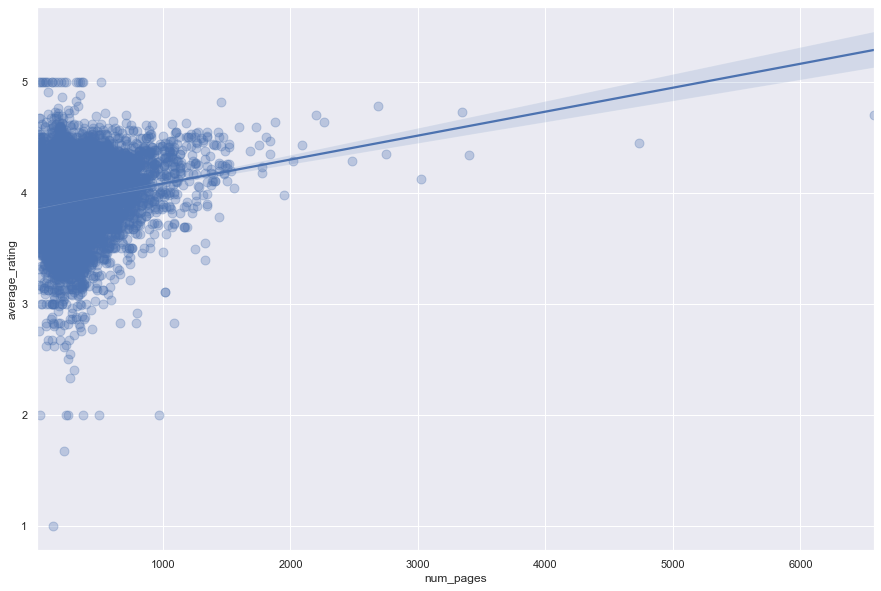

In [9]:
# задаем стиль графика
sns.set_theme(color_codes=True)
# устанавливаем размер графика
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x='num_pages', y='average_rating', data=db, scatter_kws={'s': 80, 'alpha': 0.3})

Интерпретация графика: точка пересечения линии регрессии с осью Y находится в районе 3.9 (в данном случае это не имеет значения, так как в этой точке X принимает значение 0, а книг с таким количеством страниц не бывает). Наклон линии говорит о том, что num_pages оказывает влияние на оценку. Наклон положительный, то есть чем больше страниц, тем выше оценка. 

Рассмотрим дополнительные техники построения графиков линейной регрессии. Начнем с полиномиальной регрессии.

<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

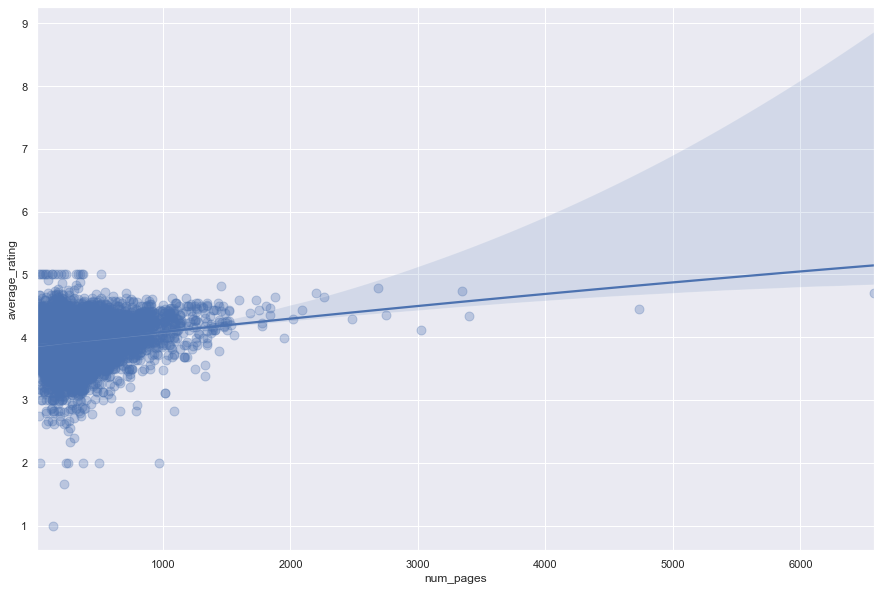

In [10]:
 fig, ax = plt.subplots(figsize=(15,10))
 # полиномиальная регрессия
 sns.regplot(x='num_pages', y='average_rating', data=db, scatter_kws={'s':80, 'alpha':0.3}, order=2)

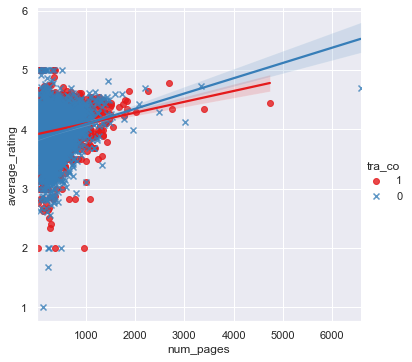

In [11]:
# регрессия с третьим признаком, который задан цветом
sns.lmplot(x='num_pages', y='average_rating', hue='tra_co', data=db, markers=["o", "x"], palette="Set1")

<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

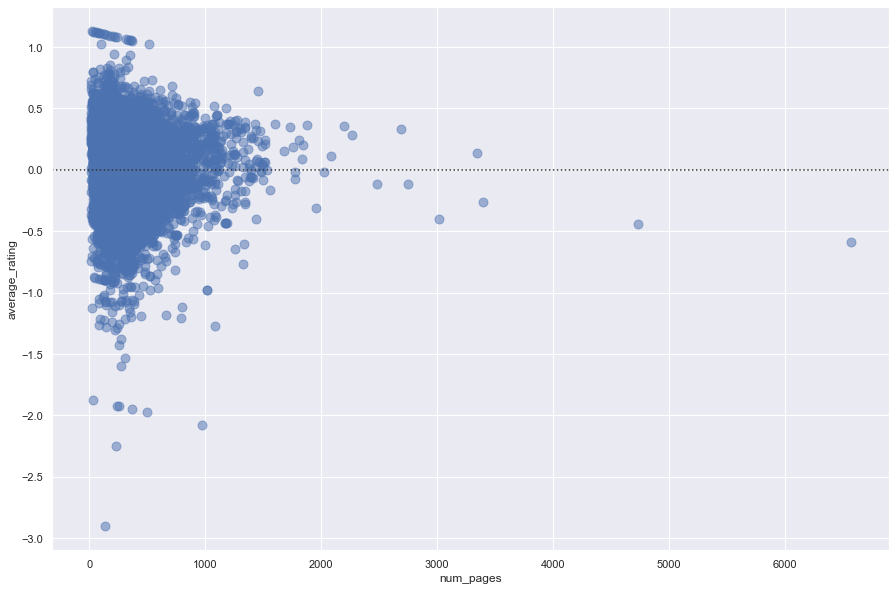

In [12]:
 fig, ax = plt.subplots(figsize=(15,10))
 # график остатков
 sns.residplot(x='num_pages', y='average_rating', data=db, scatter_kws={'s':80, 'alpha':0.5})

Интерпретация графика. Разброс ошибок должен быть одинаков вдоль оси X. Это значит, что разница между самой болбшой и самой маленкьой ошибкой для каждого значения X должна быть одинакова на всем протяжении оси X. В нашем случае это не так. Например, в районе 0-100 по X мы видим, что разрывы между наибольшей и наименьшей ошибкой больше, чем в районе 1000-2000.

# Статистический анализ  
Статистический анализ проведем с помощью библиотеки statsmodels. Данная библиотека дает широкий вывод оценок модели, что позволяет проверить допущения линейной регрессии. Линейная регрессия, как и многие другие статистические методы, требуют наличия определенных условий для применения. Условия следующие:  
- целевой признак - непрерывная величина, независимая - может быть непрерывной или категориальной переменной;
- оценка одной книги не зависит от оценки другой - так что целевой признак независим;
- линейность отношений - мы видели, что это слабо выполняется для num_pages, но предположим, что как для этого признака,так и для остальных это выполняется;
- непрерывные переменные должны быть нормально распределены и не должны иметь выбросов, нам уже известно, что данные не распределены нормально;
- гомоскедастичность, то есть постоянство ошибок предсказания модели. Это проверяется после построения модели;
- нормальность распределения ошибок - также проверяется после построения модели;
- если мы применяем два и более признака, то необходима проверка на мультиколлинеарность, это тоже проверяется после построения модели.

#  Проверка условий для применения линейной регрессии

In [13]:
# применим тест Шапиро для проверки данных на нормальность распределения
pg.normality(db['average_rating'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


W          pval  normal
average_rating  0.973475  1.377196e-40   False

In [14]:
pg.normality(db['num_pages'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


W  pval  normal
num_pages  0.771622   0.0   False

In [15]:
pg.normality(db['ratings_count'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


W  pval  normal
ratings_count  0.127581   0.0   False

In [16]:
pg.normality(db['text_reviews_count'])

/Users/Shared/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


W  pval  normal
text_reviews_count  0.180052   0.0   False

Тест показывает, что данные не распределены нормально. В этом случае можно преобразовать данные или удалить выбросы.  
Сначала удалим выбросы, проверим данные на нормальность, если это не поможет, то преобразуем данные.  
Мы можем не только удалить выбросы, но и сделать их самостоятельным объектом исследования. На практике удаление выбросов это крайняя мера (?).

In [17]:
# удалим выбросы
for x in ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']:
    q1, q3 = np.percentile(db[x], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    db = db.loc[(db[x] < upper_bound) & (db[x] > lower_bound)]

/Users/Shared/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


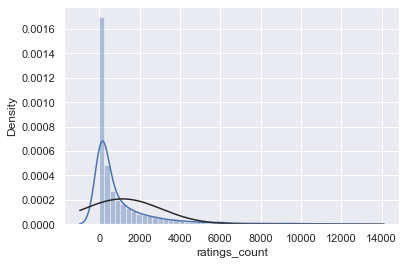

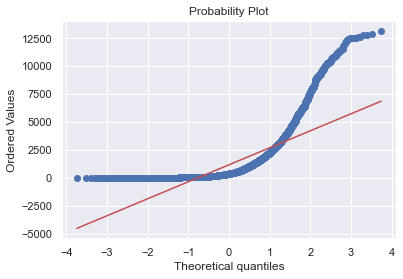

In [18]:
# проверим на нормальность
from scipy.stats import norm # пример скошенных данных на графике
sns.distplot(db['ratings_count'], fit=norm)
fig = plt.figure() 
res = stats.probplot(db['ratings_count'], plot=plt) # получаем практически нормально распределение

In [19]:
# данные незначительно скошены влево
db['average_rating'].skew()

-0.11276716804191525

In [20]:
# данные скошены вправо
db['num_pages'].skew()

0.55195724170108

In [21]:
# данные скошены вправо
db['ratings_count'].skew()

2.8605237582010004

In [22]:
# данные скошены вправо
db['text_reviews_count'].skew()

1.5563535725435345

Скошенность для средней оценки небольшая, поэтому не будем ее преобразовывать.  
Для скошенности вправо подходит преобразование через логарифм. Логарифмирование позволяет большие значения в наборе приблизить к центру

In [23]:
# пример преобразования через логарифм 
a = 0.001 # преобразование к нормальному
num_pages_log = np.log(db['num_pages'] + a) # логарифм
num_pages_log.skew()


-1.255890076353213

 Видим, что преобразование не помогло, поэтому не будем преобразовывать наши данные.

 # Построение линейной регрессии

In [24]:
a = db['num_pages'] # добалвяем константу для правильного вывода
a_const = sm.add_constant(a, prepend=False)
model = sm.OLS(db['average_rating'], a_const) # обучаем модель
results = model.fit() # получаем результат
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     45.30
Date:                Mon, 24 May 2021   Prob (F-statistic):           1.82e-11
Time:                        18:01:00   Log-Likelihood:                -645.44
No. Observations:                7611   AIC:                             1295.
Df Residuals:                    7609   BIC:                             1309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
num_pages      0.0001   1.97e-05      6.730      0.0

Описание таблицы вывода:  
- Dep. Variable - зависимая переменная (целевой признак), в данном случае average_rating
- Model - применяемая модель
- Method - метод построения линейной регрессии
- Date, Time - дата и время создания модели
- No. Observation - количество элементов (строк, наблюдений) в данных
- Df Residuals - остатки
- R-squared - коэффициент детерминации, то есть количество дисперсии, которая объясняется нашей моделью. В данном случае это нули, то есть num_pages не объясняет целевой признак. Этот коэффициент представляет собой квадрат коэффициента корреляции между реальными и предсказанными значениями.
- Adj. R-squared - тоже самое, но с учетом специальной поправки
- F-statistic - позволяет ответить на вопрос: лучше ли наша модель, чем модель, в которой все коэффициенты равны нулю. F-statistic равна 3 при p-value < 0.05, то есть нулевую гипотезу о случайности мы не можем отвергнуть
- Prob (F-statistic) - вероятность получить значение случайно, у нас высокая
- coef - коэффициент в формуле линейной регрессии, на который умножается значение признака, коэффициент наклона. У нас это 0.001, то есть коэффициент не значим, мы можем предсказать значение просто по точке пересечения прямой с осью Y
- std err - насколько фактические значения отличаются от регрессионной прямой. Это усредненная ошибка предсказания оценки книги по количеству страниц
- t - статистика показывает важность переменных в модели и получается в результате деления регрессионного коэффициента для признака на стандартную ошибку коэффициента. Чем выше  t-статистика и ниже p-значение, тем более значим признак. 
- P > |t| - вероятность получить значение случайно
- [0.025 0.975] - доверительные интервалы для коэффициента  

Нижняя часть вывода - это проверка на соблюдение условий для применения линейной регрессии. Здесь исследуются остатки. Если условия по остаткам не выполняются, то мы не можем принять результаты линейной регрессии.

- Omnibus - это тест на нормальное распределение остатков. Вероятность (Prob(Omnibus)) должна стремиться к 1, чтобы можно было сказать, что остатки распределены нормально. В нашем случае это не выполняется.
- Skew - перекос графика распределения остатков. В идеале перекоса не должно быть, а значит значение должно быть равно 0. У нас это не так, есть левосторонний перекос.
- Kurtosis - показатель "остроты" пика графика распределения остатков.
- Durbin-Watson - тест на гомоскедастичность остатков, статистика может принимать значения от 0 до 4, значение 2 показывает независимость остатков. У нас значение 1.517
- Jarque-Bera - еще один тест на нормальность
- Cond No. - тест на мультиколлинеарность

Суть полученного результата в том, что коэффициент при значениях признака равен 0, может быть отброшен. Но в этом случае наша регрессионная линия может просто объясняться точкой пересечения с осью Y, то есть не имеет никакого наклона.


In [25]:
# пример дополнительной статистики для определения выбросов, влиятельных наблюдений
influence = results.get_influence() # получаем статистику
inf_sum = influence.summary_frame() # строим таблицу со статистикой
num_page_inf = pd.concat([db['num_pages'], inf_sum], axis=1) # объединяем
num_page_inf

num_pages  dfb_num_pages  dfb_const       cooks_d  standard_resid  \
2            352       0.007195   0.003019  2.385564e-04        1.799143   
5            152       0.007473  -0.010218  5.847620e-05       -0.681821   
13           256       0.000766  -0.001941  4.096418e-06       -0.240597   
25           224      -0.012087   0.022102  3.816437e-04        2.167316   
26           558      -0.009833   0.006095  6.521985e-05       -0.506615   
...          ...            ...        ...           ...             ...   
10833        512       0.005619  -0.003156  2.392639e-05        0.351903   
10834        635       0.009213  -0.006279  5.124867e-05        0.365983   
10835        415       0.000183  -0.000053  4.590087e-08        0.021044   
10836        434      -0.009116   0.003400  9.474578e-05       -0.899718   
10837        272       0.000192  -0.000678  6.340142e-07       -0.096792   

       hat_diag  dffits_internal  student_resid    dffits  
2      0.000147         0.021843       1.799408  0.021846  
5      0.000252        -0.010814      -0.681797 -0.010814  
13     0.000142        -0.002862      -0.240582 -0.002862  
25     0.000162         0.027628       2.167843  0.027634  
26     0.000508        -0.011421      -0.506591 -0.011420  
...         ...              ...            ...       ...  
10833  0.000386         0.006918       0.351882  0.006917  
10834  0.000765         0.010124       0.365962  0.010124  
10835  0.000207         0.000303       0.021042  0.000303  
10836  0.000234        -0.013766      -0.899707 -0.013765  
10837  0.000135        -0.001126      -0.096786 -0.001126  

[7611 rows x 9 columns]

In [26]:
X = db[['num_pages', 'ratings_count']]
y = db['average_rating']
X = sm.add_constant(X)
model_mult = sm.OLS (y, X)
results2 = model_mult.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     53.76
Date:                Mon, 24 May 2021   Prob (F-statistic):           6.52e-24
Time:                        18:01:17   Log-Likelihood:                -614.62
No. Observations:                7611   AIC:                             1235.
Df Residuals:                    7608   BIC:                             1256.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.8891      0.007    579.269

Это пример множественной линейной регрессии. Требуются теже условия плюс мультиколлинеарность. Это можно сделать с помощью коэффициентов корреляции, а можно использовать Variance Inflation Factor, если у нас 3 и более признака, у нас меньше, но воспользуемся этим методом для демонстрации.

In [27]:
# дополнительный инструмент для проверки
from statsmodels.stats.outliers_influence import variance_inflation_factor
# с помощью данной библиотеки можно преобразовать данные в формат, который понятен statsmodel
import patsy
x = patsy.dmatrix("num_pages + ratings_count", data = db)
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
vif['Features'] = x.design_info.term_names
vif

VIF Factor       Features
0    4.983668      Intercept
1    1.007672      num_pages
2    1.007672  ratings_count

Первую строку в выводе можно проигнорировать. Если в других строках VIF > 10, то имеется мультиколлинеарность. Вывод: ratings_count помогает улучшить модель. Оставляем num_pages, ratings_count и добавляем последний количественный признак.

In [28]:
X = db[['num_pages', 'text_reviews_count', 'ratings_count']]
y = db['average_rating']
X = sm.add_constant(X)
model_mult = sm.OLS (y, X)
results3 = model_mult.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     65.55
Date:                Mon, 24 May 2021   Prob (F-statistic):           7.73e-42
Time:                        18:01:17   Log-Likelihood:                -570.91
No. Observations:                7611   AIC:                             1150.
Df Residuals:                    7607   BIC:                             1178.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9037      0

Второе примечание говорит о том, что возможна мультиколлинеарность. Это оправдано, так как из нашего статистического анализа мы знаем, что text_reviews_count и ratings_count имеют сильную корреляцию.

В нашей лучшей модели text_reviews_count имеет отрицательный коэффициент, здесь можно выдвинуть предположение, что увеличение количества отзывов уменьшает оценку.

Посмотрим еще несколько техник.

In [29]:
 import statsmodels.formula.api as smf
 sm.OLS.from_formula
 mod = smf.ols('average_rating ~ C(decade)', data = db) # категориальные данные
 res = mod.fit()
 print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.663
Date:                Mon, 24 May 2021   Prob (F-statistic):             0.0753
Time:                        18:01:17   Log-Likelihood:                -658.88
No. Observations:                7611   AIC:                             1342.
Df Residuals:                    7599   BIC:                             1425.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.8800      0.26

In [30]:
# проверка на взаимодействие
mod = smf.ols('average_rating ~ ratings_count*text_reviews_count', data = db)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     59.93
Date:                Mon, 24 May 2021   Prob (F-statistic):           2.77e-38
Time:                        18:01:17   Log-Likelihood:                -579.14
No. Observations:                7611   AIC:                             1166.
Df Residuals:                    7607   BIC:                             1194.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

# Машинное обучение  
Чтобы применять машинное обучение, нужно ответить на несколько вопросов.  

1. Какую выбрать модель? У нас это линейная регрессия (возможно расширение до полиномиальной или применение регуляризации).
2. Требуется ли дополнительная подготовка данных для выбранной модели? Например, мы можем добавить дополнительные признаки в ручном режиме или автоматически. Или придется стандартизировать наши данные, если мы собираемся получить новые признаки умножением двух отдельных (то есть приводим к одному масштабу). Отчасти мы уже начали это делать, так как привели данные к нормальному распределению.
3. Какие параметры модели мы будем настраивать и как? Будем использовать решетчатый поиск с кросс-валидацией.
4. Что будет нашей оценкой качества модели? MSE и R2
5. Как мы можем получить предсказания по новым данным?

Порядок действий:  
1) задаем модель линейной регрессии;  
2) разделяем данные на тренировочный и тестовый наборы;  
3) подготавливаем данные (возможно с применением метода Pipeline);  
4) тренируем модель с настройкой параметров и оценкой;  
5) выбираем лучшую модель;  
6) проводим проверку на тестовом наборе;  
7) применяем для новых данных. 

Важно помнить следующие обстоятельства:

1. всегда следует стремиться найти самую простую и эффективную модель, поэтому начинать стоит с базовой.
2. когда мы готовим наши данные для машинного обучения, мы можем добавлять признаки, очищать их, модифицировать до разделения на тренировочный и тестовый набор или после. До разделения мы можем применять только нематематические методы, которым не требуются расчеты на всем датафрейме. Все математические методы, которые требуют расчетов, надо применять только после разделения на тренировочный и тестовый наборы, причем только на тренировочном (с последующим применением результатов и к тестовому).

Мы должны преобразовать наши данные. Это можно сделать для количественных и категориальных отдельно, а можно воспользоваться специальным инструментом Pipeline. Рассмотрим оба варианта для лучшего понимания.

Желательно давать подробное наименование для переменных.

# Создание данных

In [31]:
db_train = db.sample(frac=0.7, random_state=200) # создаем тренировочный набор
db_test = db.drop(db_train.index) # создаем обучающий набор

In [32]:
books = db_train.drop(['average_rating'], axis=1) # это наши признаки
books_labels = db_train['average_rating'] # это наш целевой признак

# Подготовка данных без Pipeline
### Заполнение пропусков
Все нижеследующие действия мы должны проводить только на обучающем наборе.  
В  наших данных нет пропусков, но в демонстрационных целях предположим, что они есть.

In [33]:
# инструмент для заполнения пропусков
imputer = SimpleImputer(strategy='median')

In [34]:
# оставляем только количественные признаки
books_num_1 = books.select_dtypes(include=[np.number])

In [35]:
# обучаем для заполнения пропусков
imputer.fit(books_num_1)

SimpleImputer(strategy='median')

In [36]:
# заполняем пропуски
X = imputer.transform(books_num_1)
# возвращаемся к формату датафрейма
books_tr = pd.DataFrame(X, columns=books_num_1.columns, index=books.index)
books_tr

num_pages  ratings_count  text_reviews_count
9931      223.0           77.0                10.0
5440      144.0          564.0                49.0
8135      206.0           37.0                 1.0
4739      144.0         6881.0               187.0
5551      136.0            4.0                 0.0
...         ...            ...                 ...
9716      160.0          923.0               112.0
470       232.0           12.0                 2.0
9076      101.0            5.0                 3.0
4200      384.0         3009.0                28.0
6774      192.0         8634.0               118.0

[5328 rows x 3 columns]

### Кодирование категориальных данных

In [37]:
# оставляем только категориальные признаки
books_cat_1 = books[['tra_co', 'quarter', 'decade']]
books_cat_1.head()

tra_co quarter decade
9931      0       3   1990
5440      0       4   1990
8135      0       4   2000
4739      0       2   2000
5551      1       1   2000

In [38]:
# инструмент кодирования категориальной переменной
ohe = OneHotEncoder()
books_cat_1hot = ohe.fit_transform(books_cat_1)
books_cat_1hot

<5328x17 sparse matrix of type '<class 'numpy.float64'>'
	with 15984 stored elements in Compressed Sparse Row format>

In [39]:
# возвращаемся к матричной форме
books_cat_1hot.toarray()

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

### Подготовка данных с Pipeline

In [42]:
# вернемся к первоначальным данным
db_train = db.sample(frac=0.7, random_state=200) # создаем тренировочный набор
db_test = db.drop(db_train.index) # создаем обучающий набор

books = db_train.drop(['average_rating'], axis=1) # удалим часть признаков для упрощения задачи
books_labels = db_train['average_rating']

In [44]:
# для обработки количественных данных
books_num = books.select_dtypes(include=[np.number]) # оставляем только количественные признаки
# дополнительно проводим стандартизацию
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

In [45]:
num_atrib = list(books_num) # количественные признаки
cat_atrib = ['tra_co', 'decade', 'quarter'] # количественные признаки

In [46]:
full_pipe = ColumnTransformer([('num', num_pipeline, num_atrib), ('cat', OneHotEncoder(handle_unknown='ignore'), cat_atrib)]) # применяемый инструмент мы можем указать непосредственно в трубе, например ohe

In [47]:
books_prepared = full_pipe.fit_transform(books)
books_prepared

array([[-0.48419803, -0.55851495, -0.66203218, ...,  0.        ,
         1.        ,  0.        ],
       [-1.00279049, -0.30583967, -0.07188031, ...,  0.        ,
         0.        ,  1.        ],
       [-0.59579387, -0.57926857, -0.79822107, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.28506233, -0.59587146, -0.76795687, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.57268027,  0.96272513, -0.38965439, ...,  0.        ,
         0.        ,  1.        ],
       [-0.68769633,  3.88120242,  0.97223453, ...,  0.        ,
         1.        ,  0.        ]])

In [48]:
books_prepared.shape # увеличилось количество столбцов

(5328, 20)

### Обучение

In [49]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
# на оси X (или осях, если признаков несколько) откладываем признаки, на оси Y целевой признак
lin_reg.fit(books_prepared, books_labels)

LinearRegression()

### Предсказание

In [50]:
some_data = books.iloc[:5]
some_labels = books_labels.iloc[:5]
some_data_prepared = full_pipe.transform(some_data)

print("Прогноз:", lin_reg.predict(some_data_prepared)) # эти оценки получит наша книга

Прогноз: [3.90543324 3.89358631 3.90814963 3.95784594 3.93818243]


In [52]:
print("Прогноз:", list(some_labels)) # это реальные данные

Прогноз: [3.85, 3.9, 4.57, 3.87, 4.25]


### Оценка

In [53]:
from sklearn.metrics import mean_squared_error

In [54]:
# проверка модели с помощью MSE на обучающих данных
books_predict = lin_reg.predict(books_prepared)
lin_mse = mean_squared_error(books_labels, books_predict)
lin_mse 

0.06722479659796249

In [55]:
# проверка модели с помощью коэффициента детерминации R2 на обучающих данных
lin_reg.score(books_prepared, books_labels)

0.044412538541836244

Интерпретация: коэффициент детеримнации в идеале должен быть 1. У нас только 0.04, что крайне низко.  
Наша модель способная объяснять только 4% дисперсии данных. MSE показывает ошибку между предсказанным и фактическим значениями. Для обучающих данных ошибка 0.07 весьма значительна.  
Теперь проверим данных на тестовых данных и на случайных данных. На тестовом наборе мы можем применить инструменты, обученные на обучающем наборе, но не можем их заново обучить на тестовом наборе.


In [56]:
# подготовим тестовые данные
books_test = db_test.drop(['average_rating'], axis=1)
books_test_labels = db_test['average_rating']

In [58]:
books_test_prepared = full_pipe.transform(books_test)
# ранее мы обучили full_pipe на обучающем наборе, здесь мы можем траснформировать данные, но не обучать

In [59]:
# проверка модели с помощью MSE на тренировочных данных
books_test_predict = lin_reg.predict(books_test_prepared)
lin_mse = mean_squared_error(books_test_labels, books_test_predict)
lin_mse

0.06710539133758081

На тренировочных данных ошибка больше.

In [60]:
# проверка модели с помощью коэффициента детерминации R2 на тренировочных данных
lin_reg.score(books_test_prepared, books_test_labels)

0.019628383907210445

Детерминация здесь объясняет меньше.

In [61]:
# проверка на случайных данных
from sklearn.dummy import DummyRegressor

In [62]:
dummy = DummyRegressor(strategy='mean')

In [63]:
dummy.fit(books_prepared, books_labels)

DummyRegressor()

In [64]:
dummy.score(books_test_prepared, books_test_labels) # коэффициент детерминации на случайных данных

-0.00041913509846058794

Наша модель лучше случайной.

## Дополнительные возможности

Мы можем рекурсивно удалить признаки, которые имеют наименьшее значение.

In [65]:
# рекурсивное устранение признаков
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=lin_reg, step=1, scoring='neg_mean_squared_error')
rfecv.fit(books_prepared, books_labels)
rfecv.n_features_ # столько признаков мы должны оставить

18

In [66]:
rfecv.support_ # это наши признаки

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True])

In [67]:
rfecv.ranking_ # это их ранги

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1])

### Настройка параметров

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
parameters = {'fit_intercept':(True, False)} # задаем проверяемы параметр

In [70]:
grid = GridSearchCV(lin_reg, parameters) # по умолчанию cv=5

In [71]:
grid.fit(books_prepared, books_labels) # обучаем

GridSearchCV(estimator=LinearRegression(),
             param_grid={'fit_intercept': (True, False)})

In [72]:
grid.best_params_ # получаем лучший параметр

{'fit_intercept': True}

### Инспекция модели

In [73]:
# проверяем, насколько наша оценка зависит от размера тренировочного набора
from sklearn.model_selection import learning_curve

In [82]:
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), books_prepared, books_labels, cv=10, train_sizes=np.linspace(0.01, 1.0, 50))

In [83]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

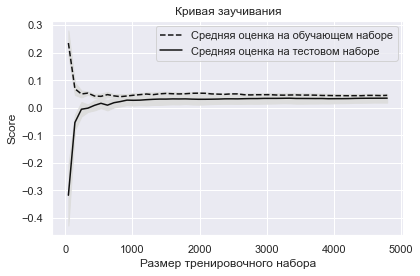

In [84]:
plt.plot(train_sizes, train_scores_mean, '--', color='#111111', label='Средняя оценка на обучающем наборе')
plt.plot(train_sizes, test_scores_mean, color='#111111', label='Средняя оценка на тестовом наборе')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='#DDDDDD')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='#DDDDDD')

plt.title('Кривая заучивания')
plt.xlabel('Размер тренировочного набора')
plt.ylabel('Score')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Интерпретация: пунктирная линия - оценка на обучающем наборе, чем больше данных, тем хуже оценка, значит у нас значительное смещение. Сплощная линия - оценка на тестовом наборе, чем больше данных, тем выше оценка. Однако эта оценка стабилизируется на значении 0.9 и не изменяется с добавлением новых данных. Дисперсия небольшая, разрыв между линиями маленький. Таким образом, наша модель недообучена на обучающих данных.


# Полиномиальная регрессия

In [85]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [86]:
interaction = PolynomialFeatures(3, include_bias=False)
books_prepared_interaction = interaction.fit_transform(books_prepared)

In [87]:
regression = LinearRegression()

In [88]:
model = regression.fit(books_prepared_interaction, books_labels)

In [89]:
model.score(books_prepared_interaction, books_labels)

0.1143475660065768

In [90]:
books_predict_interaction = model.predict(books_prepared_interaction)
lin_mse = mean_squared_error(books_labels, books_predict_interaction)
lin_mse

0.06230492459669519

# Ridge

регуляризация

In [91]:
from sklearn.linear_model import Ridge

In [92]:
regression = Ridge(alpha=0.5)

In [93]:
model = regression.fit(books_prepared, books_labels)

In [94]:
pred_b = model.predict(books_test_prepared)

In [95]:
mse = mean_squared_error(books_test_labels, pred_b)
mse

0.06710153464452459

In [96]:
from sklearn.linear_model import RidgeCV # попробуем улучшить модель

In [97]:
regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])
model_cv = regr_cv.fit(books_prepared, books_labels)
model_cv.alpha_ # лучший параметр, используем его

10.0

In [98]:
regression = Ridge(alpha=10)
model = regression.fit(books_prepared, books_labels)
pred_b = model.predict(books_test_prepared)
mse = mean_squared_error(books_test_labels, pred_b)
mse # получили небольшое улучшение

0.06709060977379093

# Lasso

In [99]:
from sklearn.linear_model import Lasso
regression = Lasso(alpha=10)
model_l = regression.fit(books_prepared, books_labels)
model_predict = model_l.predict(books_test_prepared)
mse = mean_squared_error(books_test_labels, model_predict)
mse

0.06847762262838943

# SGDRegressor
градиентный спуск

In [100]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(books_prepared, books_labels)
sgd_reg.intercept_, sgd_reg.coef_

(array([2.12554458]),
 array([ 2.43155913e-02,  5.78980683e-02, -4.45358331e-02,  1.04071012e+00,
         1.08483446e+00,  1.72324877e-02,  1.15839434e-01,  1.96232582e-04,
         1.09427550e-01,  2.61564879e-01,  2.68463234e-01,  2.54875165e-01,
         2.54111338e-01,  2.88019708e-01,  2.56391268e-01,  2.99423287e-01,
         5.23514168e-01,  5.26788253e-01,  5.26090057e-01,  5.49152106e-01]))

In [101]:
sgd_pred = sgd_reg.predict(books_test_prepared)

In [102]:
mse = mean_squared_error(books_test_labels, sgd_pred)
mse

0.06948336006805808